In [1]:
import os
import glob
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn\
    
from torch.utils.data import Dataset, DataLoader
from skimage.restoration import denoise_wavelet

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_directory = "./data/CEBS/m001"
sampling_rate = '1S' # https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
target_snr_db = 20

num_epochs = 1000
batch_size = 4
learning_rate = 0.001

In [3]:
def signaltonoise_dB(signal_clean, signal_noisy):
    signal_clean_watts = signal_clean ** 2
    signal_clean_avg_watts = np.mean(signal_clean_watts)
    signal_clean_avg_db = 10 * np.log10(signal_clean_avg_watts)

    noise = signal_noisy - signal_clean
    noise_watts = noise ** 2
    noise_avg_watts = np.mean(noise_watts)
    noise_avg_db = 10 * np.log10(noise_avg_watts)

    return signal_clean_avg_db - noise_avg_db

In [4]:
def load_dataset(directory):
    record = wfdb.rdsamp(directory)
    data = record[0]
    metadata = record[1]

    # frequency = metadata['fs']
    column_names = metadata['sig_name']
    # length = metadata['sig_len']

    data = pd.DataFrame(data, columns=column_names)
    data.drop(['I', 'II', 'RESP'], axis=1, inplace=True)

    # frequency_string = str(int(1/frequency*1000000)) + 'U'
    # index = pd.date_range(start='1/1/1970', periods=length, freq=frequency_string)
    # data.set_index(index, inplace=True)
    # data.resample(sampling_rate).mean().SCG
    
    return data

In [5]:
def load_datasets(directory):

    filenames = list(dict.fromkeys([x[:-4] for x in glob.glob(r'./data/CEBS/*[0-9][0-9][0-9].*')]))
    data = pd.concat((load_dataset(filename) for filename in filenames), ignore_index=True)

    frequency = 5000
    length = data.shape[0]
    frequency_string = str(int(1/frequency*1000000)) + 'U'
    index = pd.date_range(start='1/1/1970', periods=length, freq=frequency_string)
    data.set_index(index, inplace=True)

    return data

In [6]:
def add_gaussian(data, target_snr_db):
    data_watts = data ** 2
    data_avg_watts = np.mean(data_watts)
    data_avg_db = 10 * np.log10(data_avg_watts)

    noise_avg_db = data_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)

    mean_noise = 0
    noise = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(data_watts))

    data_noisy = data + noise
    return data_noisy

In [7]:
class DeNoise(nn.Module):
    def __init__(self):
        super(DeNoise, self).__init__()

        self.lin1 = nn.Linear(1000, 500)
        self.lin_t1 = nn.Linear(500, 1000)

    def forward(self, x):
        x = torch.tanh(self.lin1(x))
        x = self.lin_t1(x)
        return x

In [8]:
class SCGData(Dataset):

    def __init__(self, transform=None):

        data = load_datasets('./data/CEBS/')
        data = data.resample(sampling_rate).mean().SCG

        data_noisy = add_gaussian(data, target_snr_db)
        data = pd.DataFrame({'clean': data, 'noise': data_noisy})
        data = data.groupby((data.index - data.index[0]).total_seconds() // 1000).agg(list) # 1000 sec
        data = data[data['clean'].apply(lambda x: len(x) == 1000)]
        
        self.x_data = data.noise.values
        self.y_data = data.clean.values

        self.transform = transform
        self.n_samples = data.shape[0]

    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index]

        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    def __len__(self):
        return self.n_samples


class ToTensor:
    def __call__(self, sample):
        inputs, targets = sample
        return torch.Tensor(inputs), torch.Tensor(targets)

In [9]:
dataset = SCGData(transform=ToTensor())

In [10]:
model = DeNoise().to(device)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
n_total_steps = len(dataloader)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train(n_epochs, model):
    
    for epoch in range(n_epochs):
        trainloss = 0.0
        for i, (inputs, lables) in enumerate(dataloader):
            
            inputs = inputs.to(device)
            lables = lables.to(device)
            
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, lables)
            loss.backward()
            optimizer.step()
            trainloss += loss.item()

            if (i + 1) % 6 == 0:
                print(f'epoch {epoch + 1} / {n_epochs}, step {i + 1} / {n_total_steps}, loss = {loss.item():.4f}')

train(num_epochs, model)

FILE = 'model.pth'
torch.save(model.state_dict(), FILE)

epoch 1 / 1000, step 6 / 18, loss = 0.1095
epoch 1 / 1000, step 12 / 18, loss = 0.1220
epoch 1 / 1000, step 18 / 18, loss = 64.0458
epoch 2 / 1000, step 6 / 18, loss = 0.0796
epoch 2 / 1000, step 12 / 18, loss = 0.3785
epoch 2 / 1000, step 18 / 18, loss = 0.2735
epoch 3 / 1000, step 6 / 18, loss = 0.0663
epoch 3 / 1000, step 12 / 18, loss = 0.0825
epoch 3 / 1000, step 18 / 18, loss = 0.1764
epoch 4 / 1000, step 6 / 18, loss = 0.1063
epoch 4 / 1000, step 12 / 18, loss = 0.0324
epoch 4 / 1000, step 18 / 18, loss = 199.0411
epoch 5 / 1000, step 6 / 18, loss = 0.0518
epoch 5 / 1000, step 12 / 18, loss = 0.0968
epoch 5 / 1000, step 18 / 18, loss = 0.1115
epoch 6 / 1000, step 6 / 18, loss = 0.0905
epoch 6 / 1000, step 12 / 18, loss = 0.1740
epoch 6 / 1000, step 18 / 18, loss = 0.0681
epoch 7 / 1000, step 6 / 18, loss = 0.3276
epoch 7 / 1000, step 12 / 18, loss = 0.2708
epoch 7 / 1000, step 18 / 18, loss = 0.0645
epoch 8 / 1000, step 6 / 18, loss = 0.0917
epoch 8 / 1000, step 12 / 18, loss = 

20.85844874382019
45.28265953063965


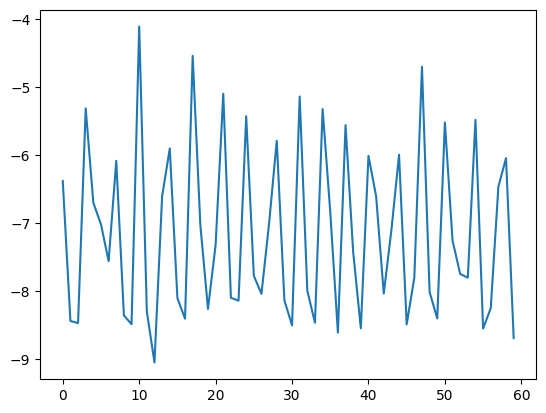

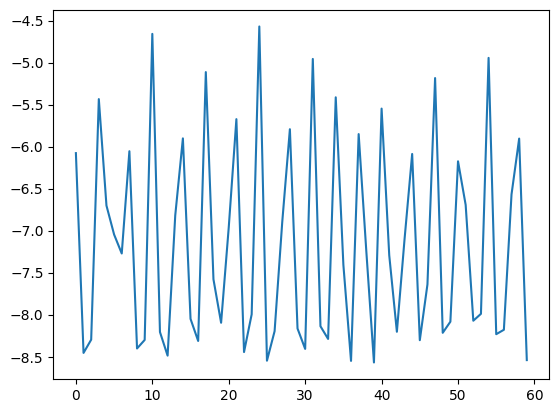

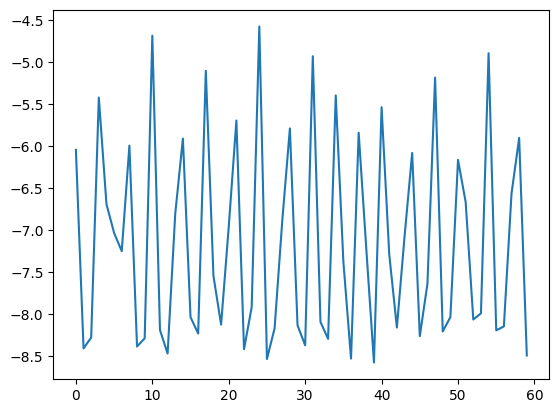

In [11]:
with torch.no_grad():

    #denoised = denoise_wavelet(data.noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
    
    noise = dataset[0][0].to(device)
    clean = dataset[0][1].to(device)

    predicted = model(noise).to('cpu').numpy()
    clean = clean.to('cpu').numpy()
    noise = noise.to('cpu').numpy()

    print(signaltonoise_dB(clean, noise))
    print(signaltonoise_dB(clean, predicted))

    time = 60
    plt.plot(range(time), noise[:time])
    plt.show()
    plt.plot(range(time), clean[:time])
    plt.show()
    plt.plot(range(time), predicted[:time])
    plt.show()